<a href="https://colab.research.google.com/github/358Xin/DL/blob/main/Seq2Seq_T.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
!pip install --upgrade jupyter ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92 kB 9.9 MB/s 
     |████████████████████████████████| 880 kB 25.4 MB/s 
     |████████████████████████████████| 1.2 MB 57.2 MB/s 
     |████████████████████████████████| 1.8 MB 52.9 MB/s 
     |████████████████████████████████| 181 kB 72.0 MB/s 
     |████████████████████████████████| 146 kB 72.5 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=c3bca136f1917d154736cd97553fb442923dc6293df114e00dcdc1b04e0ecfff
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=28fcae193d6afce9ba589683f76995cf52b976de9e5fbc6bdca1e55e30323b1e
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3

In [2]:
!git clone https://github.com/pytorch/fairseq.git
!cd fairseq && git checkout 9a1c497
!pip install --upgrade ./fairseq/

Cloning into 'fairseq'...
remote: Enumerating objects: 31923, done.
remote: Total 31923 (delta 0), reused 0 (delta 0), pack-reused 31923
Receiving objects: 100% (31923/31923), 22.26 MiB | 17.25 MiB/s, done.
Resolving deltas: 100% (23403/23403), done.
Note: checking out '9a1c497'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 9a1c4970 Make Hydra logging work with DDP (#1568)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./fairseq
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory

In [3]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

In [4]:
seed = 73
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [5]:
!gdown --id '15f5ZghJJ1AQ9rARr4XDNCQcfxGXtzWyt' --output ted2020.tgz
!gdown --id '18WjD1jP5p7g6E3YuAJs6PaAADvhKEbuq' --output test.tgz
!tar -xvf ted2020.tgz 
!tar -xvf test.tgz 

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=15f5ZghJJ1AQ9rARr4XDNCQcfxGXtzWyt
To: /content/ted2020.tgz
100% 28.6M/28.6M [00:00<00:00, 234MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=18WjD1jP5p7g6E3YuAJs6PaAADvhKEbuq
To: /content/test.tgz
100% 150k/150k [00:00<00:00, 93.7MB/s]
raw.en
raw.zh
test.en
test.zh


In [6]:
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
prefix = Path(data_dir).absolute() / dataset_name
prefix.mkdir(parents=True, exist_ok=True)
print(prefix)
!mv {'raw.en'} {prefix/'train_dev.raw.en'}
!mv {'raw.zh'} {prefix/'train_dev.raw.zh'}
!mv {'test.en'} {prefix/'test.raw.en'}
!mv {'test.zh'} {prefix/'test.raw.zh'}

/content/DATA/rawdata/ted2020


In [7]:
src_lang = 'en'
tgt_lang = 'zh'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

In [8]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because  I need that.
Put yourselves in my position.
非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！


In [9]:
import re

def strQ2B(ustring):
    """把字串全形轉半形"""
    # 參考來源:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # 全形空格直接轉換
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # 全形字元（除空格）根據關係轉化
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .
非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !


In [10]:
valid_ratio = 0.01 # 3000~4000句就夠了
train_ratio = 1 - valid_ratio

In [11]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

In [12]:
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' 也可
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁ t ru ly ▁a ▁great ▁ho n or ▁to ▁have ▁the ▁ op port un ity ▁to ▁come ▁to ▁this ▁st age ▁ t wi ce ▁; ▁i ' m ▁ex t re me ly ▁gr ate ful ▁.
▁i ▁have ▁been ▁ bl ow n ▁away ▁by ▁this ▁con fer ence ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁ ni ce ▁ com ment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁po s ition ▁.
▁ 非常 謝 謝 你 ▁, ▁ 克 里 斯 ▁。 ▁ 能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁ 真 是 一 大 榮 幸 ▁。 ▁我 非常 感 激 ▁。
▁這個 研 討 會 給我 留 下 了 極 為 深 刻 的 印 象 ▁, ▁我想 感 謝 大家 對我 之前 演講 的 好 評 ▁。
▁我 是由 衷 的 想 這麼 說 ▁, ▁有 部份 原因 是因為 我 真的 有 需要 ▁!
▁ 請 你們 設 身 處 地 為 我想 一 想 ▁!


In [13]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

2022-07-12 07:28:54 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='DATA/data-bin/ted2020', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=True, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=False, optimizer=None, padding_factor=8, profile=False, quantization_config_path=None, reset_logging=False, scoring='bleu', seed=1, source_lang='en', srcdict=None, suppress_crashes=False, target_lang='zh', task='translation', tensorboard_logdir=None, testpref='/content/DATA/rawdata/ted2020/test', tgtdict=None, threshold_loss_scale=None, thresholdsrc=0, t

In [14]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020",
    savedir = "./checkpoints/rnn",
    source_lang = "en",
    target_lang = "zh",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=30,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10,
    # when decoding, post process sentence by removing sentencepiece symbols.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

In [15]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

In [16]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2022-07-12 07:33:13 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2022-07-12 07:33:13 | INFO | fairseq.utils | rank   0: capabilities =  7.5  ; total memory = 14.756 GB ; name = Tesla T4                                
2022-07-12 07:33:13 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


In [17]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2022-07-12 07:33:13 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types
2022-07-12 07:33:13 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types


In [18]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2022-07-12 07:33:13 | INFO | hw5.seq2seq | loading data for epoch 1
2022-07-12 07:33:13 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.en
2022-07-12 07:33:13 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.zh
2022-07-12 07:33:13 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 train en-zh 390041 examples
2022-07-12 07:33:13 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.en
2022-07-12 07:33:13 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.zh
2022-07-12 07:33:13 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 valid en-zh 3939 examples


In [19]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([  18,   14,    6, 2234,   60,   19,   80,    5,  256,   16,  405, 1407,
        1706,    7,    2]),
 'target': tensor([ 140,  690,   28,  270,   45,  151, 1142,  660,  606,  369, 3114, 2434,
        1434,  192,    2])}
"Source: that's exactly what i do optical mind control ."
'Target: 這實在就是我所做的--光學操控思想'


In [20]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2022-07-12 07:33:13 | WARNING | fairseq.tasks.fairseq_task | 2,532 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[29, 135, 2444, 3058, 682, 731, 235, 1558, 3383, 559]


{'id': tensor([723]),
 'net_input': {'prev_output_tokens': tensor([[   2,  140,  296,  318, 1560,   51,  568,  316,  225, 1952,  254,   78,
            151, 2691,    9,  215, 1680,   10,    1,    1,    1,    1,    1,    1]]),
  'src_lengths': tensor([19]),
  'src_tokens': tensor([[   1,    1,    1,    1,    1,   18,   26,   82,    8,  480,   15,  651,
           1361,   38,    6,  176, 2696,   39,    5,  822,   92,  260,    7,    2]])},
 'nsentences': 1,
 'ntokens': 18,
 'target': tensor([[ 140,  296,  318, 1560,   51,  568,  316,  225, 1952,  254,   78,  151,
          2691,    9,  215, 1680,   10,    2,    1,    1,    1,    1,    1,    1]])}

In [21]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

In [22]:
class RNNEncoder(FairseqEncoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        self.embed_dim = args.encoder_embed_dim
        self.hidden_dim = args.encoder_ffn_embed_dim
        self.num_layers = args.encoder_layers
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=True
        )
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        self.padding_idx = dictionary.pad()
        
    def combine_bidir(self, outs, bsz: int):
        out = outs.view(self.num_layers, 2, bsz, -1).transpose(1, 2).contiguous()
        return out.view(self.num_layers, bsz, -1)

    def forward(self, src_tokens, **unused):
        bsz, seqlen = src_tokens.size()
        
        # get embeddings
        x = self.embed_tokens(src_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
        
        # 過雙向RNN
        h0 = x.new_zeros(2 * self.num_layers, bsz, self.hidden_dim)
        x, final_hiddens = self.rnn(x, h0)
        outputs = self.dropout_out_module(x)
        # outputs = [sequence len, batch size, hid dim * directions] 是最上層RNN的輸出
        # hidden =  [num_layers * directions, batch size  , hid dim]
        
        # 因為 Encoder 是雙向的RNN，所以需要將同一層兩個方向的 hidden state 接在一起
        final_hiddens = self.combine_bidir(final_hiddens, bsz)
        # hidden =  [num_layers x batch x num_directions*hidden]
        
        encoder_padding_mask = src_tokens.eq(self.padding_idx).t()
        return tuple(
            (
                outputs,  # seq_len x batch x hidden
                final_hiddens,  # num_layers x batch x num_directions*hidden
                encoder_padding_mask,  # seq_len x batch
            )
        )
    
    def reorder_encoder_out(self, encoder_out, new_order):
        # 這個beam search時會用到，意義並不是很重要
        return tuple(
            (
                encoder_out[0].index_select(1, new_order),
                encoder_out[1].index_select(1, new_order),
                encoder_out[2].index_select(1, new_order),
            )
        )

In [23]:
class AttentionLayer(nn.Module):
    def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
        super().__init__()

        self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)
        self.output_proj = nn.Linear(
            input_embed_dim + source_embed_dim, output_embed_dim, bias=bias
        )

    def forward(self, inputs, encoder_outputs, encoder_padding_mask):
        # inputs: T, B, dim
        # encoder_outputs: S x B x dim
        # padding mask:  S x B
        
        # convert all to batch first
        inputs = inputs.transpose(1,0) # B, T, dim
        encoder_outputs = encoder_outputs.transpose(1,0) # B, S, dim
        encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, S
        
        # 投影到encoder_outputs的維度
        x = self.input_proj(inputs)

        # 計算attention
        # (B, T, dim) x (B, dim, S) = (B, T, S)
        attn_scores = torch.bmm(x, encoder_outputs.transpose(1,2))

        # 擋住padding位置的attention
        if encoder_padding_mask is not None:
            # 利用broadcast  B, S -> (B, 1, S)
            encoder_padding_mask = encoder_padding_mask.unsqueeze(1)
            attn_scores = (
                attn_scores.float()
                .masked_fill_(encoder_padding_mask, float("-inf"))
                .type_as(attn_scores)
            )  # FP16 support: cast to float and back

        # 在source對應維度softmax
        attn_scores = F.softmax(attn_scores, dim=-1)

        # 形狀 (B, T, S) x (B, S, dim) = (B, T, dim) 加權平均
        x = torch.bmm(attn_scores, encoder_outputs)

        # (B, T, dim)
        x = torch.cat((x, inputs), dim=-1)
        x = torch.tanh(self.output_proj(x)) # concat + linear + tanh
        
        # 回復形狀 (B, T, dim) -> (T, B, dim)
        return x.transpose(1,0), attn_scores

In [24]:
class RNNDecoder(FairseqIncrementalDecoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        assert args.decoder_layers == args.encoder_layers, f"""seq2seq rnn requires that encoder 
        and decoder have same layers of rnn. got: {args.encoder_layers, args.decoder_layers}"""
        assert args.decoder_ffn_embed_dim == args.encoder_ffn_embed_dim*2, f"""seq2seq-rnn requires 
        that decoder hidden to be 2*encoder hidden dim. got: {args.decoder_ffn_embed_dim, args.encoder_ffn_embed_dim*2}"""
        
        self.embed_dim = args.decoder_embed_dim
        self.hidden_dim = args.decoder_ffn_embed_dim
        self.num_layers = args.decoder_layers
        
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=False
        )
        self.attention = AttentionLayer(
            self.embed_dim, self.hidden_dim, self.embed_dim, bias=False
        ) 
        # self.attention = None
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        if self.hidden_dim != self.embed_dim:
            self.project_out_dim = nn.Linear(self.hidden_dim, self.embed_dim)
        else:
            self.project_out_dim = None
        
        if args.share_decoder_input_output_embed:
            self.output_projection = nn.Linear(
                self.embed_tokens.weight.shape[1],
                self.embed_tokens.weight.shape[0],
                bias=False,
            )
            self.output_projection.weight = self.embed_tokens.weight
        else:
            self.output_projection = nn.Linear(
                self.output_embed_dim, len(dictionary), bias=False
            )
            nn.init.normal_(
                self.output_projection.weight, mean=0, std=self.output_embed_dim ** -0.5
            )
        
    def forward(self, prev_output_tokens, encoder_out, incremental_state=None, **unused):
        # 取出encoder的輸出
        encoder_outputs, encoder_hiddens, encoder_padding_mask = encoder_out
        # outputs:          seq_len x batch x num_directions*hidden
        # encoder_hiddens:  num_layers x batch x num_directions*encoder_hidden
        # padding_mask:     seq_len x batch
        
        if incremental_state is not None and len(incremental_state) > 0:
            # 有上個timestep留下的資訊，讀進來就可以繼續decode，不用從bos重來
            prev_output_tokens = prev_output_tokens[:, -1:]
            cache_state = self.get_incremental_state(incremental_state, "cached_state")
            prev_hiddens = cache_state["prev_hiddens"]
        else:
            # 沒有incremental state代表這是training或者是test time時的第一步
            # 準備seq2seq: 把encoder_hiddens pass進去decoder的hidden states
            prev_hiddens = encoder_hiddens
        
        bsz, seqlen = prev_output_tokens.size()
        
        # embed tokens
        x = self.embed_tokens(prev_output_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
                
        # 做decoder-to-encoder attention
        if self.attention is not None:
            x, attn = self.attention(x, encoder_outputs, encoder_padding_mask)
                        
        # 過單向RNN
        x, final_hiddens = self.rnn(x, prev_hiddens)
        # outputs = [sequence len, batch size, hid dim]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        x = self.dropout_out_module(x)
                
        # 投影到embedding size (如果hidden 和embed size不一樣，然後share_embedding又設成True,需要額外project一次)
        if self.project_out_dim != None:
            x = self.project_out_dim(x)
        
        # 投影到vocab size 的分佈
        x = self.output_projection(x)
        
        # T x B x C -> B x T x C
        x = x.transpose(1, 0)
        
        # 如果是Incremental, 記錄這個timestep的hidden states, 下個timestep讀回來
        cache_state = {
            "prev_hiddens": final_hiddens,
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        
        return x, None
    
    def reorder_incremental_state(
        self,
        incremental_state,
        new_order,
    ):
        # 這個beam search時會用到，意義並不是很重要
        cache_state = self.get_incremental_state(incremental_state, "cached_state")
        prev_hiddens = cache_state["prev_hiddens"]
        prev_hiddens = [p.index_select(0, new_order) for p in prev_hiddens]
        cache_state = {
            "prev_hiddens": torch.stack(prev_hiddens),
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        return

In [25]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

In [26]:
from fairseq.models.transformer import (
    TransformerEncoder, 
    TransformerDecoder,
)

def build_model(args, task):
    """ 按照參數設定建置模型 """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # 詞嵌入
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # 編碼器與解碼器
    # TODO: 替換成 TransformerEncoder 和 TransformerDecoder
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)
    
    # 序列到序列模型
    model = Seq2Seq(args, encoder, decoder)
    
    # 序列到序列模型的初始化很重要 需要特別處理
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # 初始化模型
    model.apply(init_params)
    return model

In [27]:
arch_args = Namespace(
    encoder_embed_dim=256,
    encoder_ffn_embed_dim=1024,
    encoder_layers=4,
    decoder_embed_dim=256,
    decoder_ffn_embed_dim=1024,
    decoder_layers=4,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)

# HINT: 補上Transformer用的參數
def add_transformer_args(args):
    args.encoder_attention_heads=4
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=4
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # 補上我們沒有設定的Transformer預設參數
    from fairseq.models.transformer import base_architecture 
    base_architecture(arch_args)

add_transformer_args(arch_args)
if config.use_wandb:
    wandb.config.update(vars(arch_args))
model = build_model(arch_args, task)
logger.info(model)

2022-07-12 07:33:14 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(8000, 256, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=256, out_features=256, bias=True)
          (v_proj): Linear(in_features=256, out_features=256, bias=True)
          (q_proj): Linear(in_features=256, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (fc2): Linear(in_features=1024, out_features=256, bia

In [28]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，當目標是one-hot時的cross-entropy loss. 以下同 F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        # 將一部分正確答案的機率分配給其他label 所以當計算cross-entropy時等於把所有label的log prob加起來
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # 計算cross-entropy時 加入分配給其他label的loss
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# 一般都用0.1效果就很好了
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

In [29]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

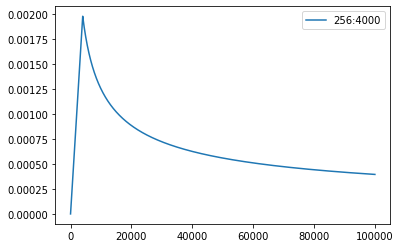

In [30]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

In [31]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # 梯度累積: 每 accum_steps 個 sample 更新一次
    
    stats = {"loss": []}
    scaler = GradScaler() # 混和精度訓練 automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # 梯度累積: 每 accum_steps 個 sample 更新一次
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # 混和精度訓練 
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # 梯度裁剪 防止梯度爆炸
        
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

In [32]:
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # 從 Tensor 轉成人看得懂的句子
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # 對於每個 sample, 收集輸入，輸出和參考答案，稍後計算 BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 代表取出 beam 內分數第一的輸出結果
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # 進行推論
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

In [33]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

In [34]:
model = model.to(device=device)
criterion = criterion.to(device=device)
!nvidia-smi

Tue Jul 12 07:33:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W /  70W |   1298MiB / 15109MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [35]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2022-07-12 07:33:27 | INFO | hw5.seq2seq | task: TranslationTask
2022-07-12 07:33:27 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2022-07-12 07:33:27 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2022-07-12 07:33:27 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2022-07-12 07:33:27 | INFO | hw5.seq2seq | optimizer: NoamOpt
2022-07-12 07:33:27 | INFO | hw5.seq2seq | num. model params: 11,469,824 (num. trained: 11,469,824)
2022-07-12 07:33:27 | INFO | hw5.seq2seq | max tokens per batch = 8192, accumulate steps = 2


In [36]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2022-07-12 07:33:27 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326674]
2022-07-12 07:33:27 | INFO | hw5.seq2seq | no checkpoints found at checkpoints/rnn/checkpoint_last.pt!


train epoch 1:   0%|          | 0/791 [00:00<?, ?it/s]

2022-07-12 07:36:32 | INFO | hw5.seq2seq | training loss: 7.0575
2022-07-12 07:36:32 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/fairseq/search.py:140: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beams_buf = indices_buf // vocab_size
/usr/local/lib/python3.7/dist-packages/fairseq/sequence_generator.py:657: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = idx // beam_size


2022-07-12 07:36:59 | INFO | hw5.seq2seq | example source: but the point is , it doesn't feel that way .
2022-07-12 07:36:59 | INFO | hw5.seq2seq | example hypothesis: 所以 , 我們有 , 這樣 , 這樣 。
2022-07-12 07:36:59 | INFO | hw5.seq2seq | example reference: 但重點是 , 感覺起來卻不是那麼回事呀
2022-07-12 07:36:59 | INFO | hw5.seq2seq | validation loss:	5.9931
2022-07-12 07:36:59 | INFO | hw5.seq2seq | BLEU = 0.72 13.9/2.1/0.4/0.1 (BP = 0.824 ratio = 0.838 hyp_len = 93695 ref_len = 111811)
2022-07-12 07:36:59 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint1.pt
2022-07-12 07:36:59 | INFO | hw5.seq2seq | end of epoch 1


train epoch 2:   0%|          | 0/791 [00:00<?, ?it/s]

2022-07-12 07:40:04 | INFO | hw5.seq2seq | training loss: 5.5265
2022-07-12 07:40:04 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 07:40:24 | INFO | hw5.seq2seq | example source: we can push through that .
2022-07-12 07:40:24 | INFO | hw5.seq2seq | example hypothesis: 我們可以從這個轉換 。
2022-07-12 07:40:24 | INFO | hw5.seq2seq | example reference: 我們可以衝破這些限制 。
2022-07-12 07:40:24 | INFO | hw5.seq2seq | validation loss:	5.0230
2022-07-12 07:40:24 | INFO | hw5.seq2seq | BLEU = 7.46 41.4/15.9/6.5/2.8 (BP = 0.714 ratio = 0.748 hyp_len = 83636 ref_len = 111811)
2022-07-12 07:40:24 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint2.pt
2022-07-12 07:40:24 | INFO | hw5.seq2seq | end of epoch 2


train epoch 3:   0%|          | 0/791 [00:00<?, ?it/s]

2022-07-12 07:43:29 | INFO | hw5.seq2seq | training loss: 4.9212
2022-07-12 07:43:29 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 07:43:51 | INFO | hw5.seq2seq | example source: thank you .
2022-07-12 07:43:51 | INFO | hw5.seq2seq | example hypothesis: 謝謝 。
2022-07-12 07:43:51 | INFO | hw5.seq2seq | example reference: 謝謝 。
2022-07-12 07:43:51 | INFO | hw5.seq2seq | validation loss:	4.5441
2022-07-12 07:43:51 | INFO | hw5.seq2seq | BLEU = 11.71 43.5/19.0/9.1/4.5 (BP = 0.862 ratio = 0.871 hyp_len = 97363 ref_len = 111811)
2022-07-12 07:43:51 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint3.pt
2022-07-12 07:43:52 | INFO | hw5.seq2seq | end of epoch 3


train epoch 4:   0%|          | 0/791 [00:00<?, ?it/s]

2022-07-12 07:46:57 | INFO | hw5.seq2seq | training loss: 4.6212
2022-07-12 07:46:57 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 07:47:23 | INFO | hw5.seq2seq | example source: those men would eventually be convicted of placing a van filled with 1 , 500 pounds of explosives into the sublevel parking lot of the world trade center's north tower , causing an explosion that killed six people and injured over 1 , 000 others .
2022-07-12 07:47:23 | INFO | hw5.seq2seq | example hypothesis: 那些男人最終會被邀請了一千五千磅的探險 , 有一千五千磅的探險中心 , 其中有一千五千磅的探險中心 , 到北極地區 , 到北極地區 , 到北極地區 , 被殺死了 。
2022-07-12 07:47:23 | INFO | hw5.seq2seq | example reference: 這群男人最終被指控將滿載1500磅重的炸彈的廂式貨車停在世界貿易中心北塔的地下停車場 , 爆炸造成6人死亡 , 同時致使超過1000人受傷 。
2022-07-12 07:47:23 | INFO | hw5.seq2seq | validation loss:	4.3158
2022-07-12 07:47:23 | INFO | hw5.seq2seq | BLEU = 13.65 45.2/20.9/10.5/5.5 (BP = 0.892 ratio = 0.898 hyp_len = 100353 ref_len = 111811)
2022-07-12 07:47:23 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint4.pt
2022-07-12 07:47:23 | INFO | hw5.seq2seq | end of epoch 4


train epoch 5:   0%|          | 0/791 [00:00<?, ?it/s]

2022-07-12 07:50:28 | INFO | hw5.seq2seq | training loss: 4.4280
2022-07-12 07:50:28 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 07:50:53 | INFO | hw5.seq2seq | example source: but this is really how i go about creating these photographs .
2022-07-12 07:50:53 | INFO | hw5.seq2seq | example hypothesis: 但這真的是我如何創造這些照片 。
2022-07-12 07:50:53 | INFO | hw5.seq2seq | example reference: 但是我真的是這樣做出這些相片的 。
2022-07-12 07:50:53 | INFO | hw5.seq2seq | validation loss:	4.1495
2022-07-12 07:50:53 | INFO | hw5.seq2seq | BLEU = 16.31 47.9/23.3/12.2/6.7 (BP = 0.941 ratio = 0.942 hyp_len = 105364 ref_len = 111811)
2022-07-12 07:50:54 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint5.pt
2022-07-12 07:50:54 | INFO | hw5.seq2seq | end of epoch 5


train epoch 6:   0%|          | 0/791 [00:00<?, ?it/s]

2022-07-12 07:53:59 | INFO | hw5.seq2seq | training loss: 4.2692
2022-07-12 07:53:59 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 07:54:23 | INFO | hw5.seq2seq | example source: so that is a fact .
2022-07-12 07:54:23 | INFO | hw5.seq2seq | example hypothesis: 這是事實 。
2022-07-12 07:54:23 | INFO | hw5.seq2seq | example reference: 這就是事實
2022-07-12 07:54:23 | INFO | hw5.seq2seq | validation loss:	3.9999
2022-07-12 07:54:23 | INFO | hw5.seq2seq | BLEU = 17.97 51.3/25.8/13.9/7.9 (BP = 0.920 ratio = 0.923 hyp_len = 103255 ref_len = 111811)
2022-07-12 07:54:24 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint6.pt
2022-07-12 07:54:24 | INFO | hw5.seq2seq | end of epoch 6


train epoch 7:   0%|          | 0/791 [00:00<?, ?it/s]

2022-07-12 07:57:30 | INFO | hw5.seq2seq | training loss: 4.1307
2022-07-12 07:57:30 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 07:57:54 | INFO | hw5.seq2seq | example source: thank you so much everyone .
2022-07-12 07:57:54 | INFO | hw5.seq2seq | example hypothesis: 非常謝謝謝
2022-07-12 07:57:54 | INFO | hw5.seq2seq | example reference: 謝謝大家 !
2022-07-12 07:57:54 | INFO | hw5.seq2seq | validation loss:	3.9272
2022-07-12 07:57:54 | INFO | hw5.seq2seq | BLEU = 18.02 54.0/27.7/15.1/8.7 (BP = 0.856 ratio = 0.866 hyp_len = 96806 ref_len = 111811)
2022-07-12 07:57:54 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint7.pt
2022-07-12 07:57:54 | INFO | hw5.seq2seq | end of epoch 7


train epoch 8:   0%|          | 0/791 [00:00<?, ?it/s]

2022-07-12 08:00:59 | INFO | hw5.seq2seq | training loss: 4.0337
2022-07-12 08:00:59 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 08:01:23 | INFO | hw5.seq2seq | example source: these differences became a source of inspired artistic celebration .
2022-07-12 08:01:23 | INFO | hw5.seq2seq | example hypothesis: 這些差異成為啟發藝術慶祝的源頭 。
2022-07-12 08:01:23 | INFO | hw5.seq2seq | example reference: 這些差異變成了一個源頭 , 富有靈感之藝術讚頌的源頭 。
2022-07-12 08:01:23 | INFO | hw5.seq2seq | validation loss:	3.8323
2022-07-12 08:01:23 | INFO | hw5.seq2seq | BLEU = 19.41 54.7/28.7/15.9/9.3 (BP = 0.885 ratio = 0.891 hyp_len = 99621 ref_len = 111811)
2022-07-12 08:01:23 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint8.pt
2022-07-12 08:01:23 | INFO | hw5.seq2seq | end of epoch 8


train epoch 9:   0%|          | 0/791 [00:00<?, ?it/s]

2022-07-12 08:04:29 | INFO | hw5.seq2seq | training loss: 3.9583
2022-07-12 08:04:29 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 08:04:54 | INFO | hw5.seq2seq | example source: it's not .
2022-07-12 08:04:54 | INFO | hw5.seq2seq | example hypothesis: 不是 。
2022-07-12 08:04:54 | INFO | hw5.seq2seq | example reference: 不是
2022-07-12 08:04:54 | INFO | hw5.seq2seq | validation loss:	3.7950
2022-07-12 08:04:54 | INFO | hw5.seq2seq | BLEU = 20.49 51.4/26.8/14.8/8.6 (BP = 1.000 ratio = 1.010 hyp_len = 112964 ref_len = 111811)
2022-07-12 08:04:54 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint9.pt
2022-07-12 08:04:54 | INFO | hw5.seq2seq | end of epoch 9


train epoch 10:   0%|          | 0/791 [00:00<?, ?it/s]

2022-07-12 08:08:00 | INFO | hw5.seq2seq | training loss: 3.9026
2022-07-12 08:08:00 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 08:08:23 | INFO | hw5.seq2seq | example source: so think about when you have friends , families and coworkers in california , on the west coast or in other parts of the world .
2022-07-12 08:08:23 | INFO | hw5.seq2seq | example hypothesis: 想想看 , 當你有朋友、家庭和同事 , 在加州的西岸或其他地區 。
2022-07-12 08:08:23 | INFO | hw5.seq2seq | example reference: 所以 , 想像當你嘗試聯繫在加州 , 在西海岸或者在世界的另一面
2022-07-12 08:08:23 | INFO | hw5.seq2seq | validation loss:	3.7354
2022-07-12 08:08:23 | INFO | hw5.seq2seq | BLEU = 20.60 55.9/29.7/16.5/9.7 (BP = 0.907 ratio = 0.911 hyp_len = 101861 ref_len = 111811)
2022-07-12 08:08:23 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint10.pt
2022-07-12 08:08:23 | INFO | hw5.seq2seq | end of epoch 10


train epoch 11:   0%|          | 0/791 [00:00<?, ?it/s]

2022-07-12 08:11:28 | INFO | hw5.seq2seq | training loss: 3.8568
2022-07-12 08:11:28 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 08:11:51 | INFO | hw5.seq2seq | example source: and i was asked to move out because one of my roommates had shared my status with her parents .
2022-07-12 08:11:51 | INFO | hw5.seq2seq | example hypothesis: 我被要求離開是因為其中一個房間和父母分享我的地位 。
2022-07-12 08:11:51 | INFO | hw5.seq2seq | example reference: 我會被要求搬出去 , 是因為其中一名室友和她的父母談了我的狀況 。
2022-07-12 08:11:51 | INFO | hw5.seq2seq | validation loss:	3.7088
2022-07-12 08:11:51 | INFO | hw5.seq2seq | BLEU = 21.18 55.4/29.4/16.5/9.7 (BP = 0.938 ratio = 0.939 hyp_len = 105042 ref_len = 111811)
2022-07-12 08:11:51 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint11.pt
2022-07-12 08:11:51 | INFO | hw5.seq2seq | end of epoch 11


train epoch 12:   0%|          | 0/791 [00:00<?, ?it/s]

2022-07-12 08:14:56 | INFO | hw5.seq2seq | training loss: 3.8209
2022-07-12 08:14:56 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 08:15:20 | INFO | hw5.seq2seq | example source: and i want to share with you a quick video from our facility that gives you a sense of how this looks at scale .
2022-07-12 08:15:20 | INFO | hw5.seq2seq | example hypothesis: 我想和各位分享一個快速的影片 , 給你們看這個規模的規模 。
2022-07-12 08:15:20 | INFO | hw5.seq2seq | example reference: 我想與你們快速分享一段關於我們設備的影片可以瞭解一下它的規模
2022-07-12 08:15:20 | INFO | hw5.seq2seq | validation loss:	3.6704
2022-07-12 08:15:20 | INFO | hw5.seq2seq | BLEU = 21.59 56.0/30.1/17.1/10.2 (BP = 0.927 ratio = 0.930 hyp_len = 103982 ref_len = 111811)
2022-07-12 08:15:20 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint12.pt
2022-07-12 08:15:20 | INFO | hw5.seq2seq | end of epoch 12


train epoch 13:   0%|          | 0/791 [00:00<?, ?it/s]

2022-07-12 08:18:25 | INFO | hw5.seq2seq | training loss: 3.7892
2022-07-12 08:18:25 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 08:18:48 | INFO | hw5.seq2seq | example source: it's a distinction perhaps we might make between two nobel laureates , richard feynman and john nash .
2022-07-12 08:18:48 | INFO | hw5.seq2seq | example hypothesis: 或許我們可能在兩個諾貝爾發射 , 理查德·費曼和約翰納許之間 。
2022-07-12 08:18:48 | INFO | hw5.seq2seq | example reference: 我們或許可以從兩位諾貝爾獎得主 , 理查費曼和約翰奈許之間看出這樣的差異 。
2022-07-12 08:18:48 | INFO | hw5.seq2seq | validation loss:	3.6582
2022-07-12 08:18:48 | INFO | hw5.seq2seq | BLEU = 21.46 57.1/30.9/17.5/10.5 (BP = 0.899 ratio = 0.903 hyp_len = 101018 ref_len = 111811)
2022-07-12 08:18:48 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint13.pt
2022-07-12 08:18:48 | INFO | hw5.seq2seq | end of epoch 13


train epoch 14:   0%|          | 0/791 [00:00<?, ?it/s]

2022-07-12 08:21:52 | INFO | hw5.seq2seq | training loss: 3.7622
2022-07-12 08:21:52 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 08:22:13 | INFO | hw5.seq2seq | example source: and therein lie the words of wisdom of a young girl whose brief life forever impacted mine .
2022-07-12 08:22:13 | INFO | hw5.seq2seq | example hypothesis: 因此 , 對於一個年輕女孩的智慧 , 說謊了我一輩子的智慧 。
2022-07-12 08:22:13 | INFO | hw5.seq2seq | example reference: 她說的話對我有很大啟發 。 這一個年幼女孩短暫的一生永遠影響著我 。
2022-07-12 08:22:13 | INFO | hw5.seq2seq | validation loss:	3.6428
2022-07-12 08:22:13 | INFO | hw5.seq2seq | BLEU = 21.11 58.3/31.6/17.9/10.7 (BP = 0.866 ratio = 0.874 hyp_len = 97706 ref_len = 111811)
2022-07-12 08:22:13 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint14.pt
2022-07-12 08:22:14 | INFO | hw5.seq2seq | end of epoch 14


train epoch 15:   0%|          | 0/791 [00:00<?, ?it/s]

2022-07-12 08:25:18 | INFO | hw5.seq2seq | training loss: 3.7436
2022-07-12 08:25:18 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 08:25:40 | INFO | hw5.seq2seq | example source: and we've started making curtains , and not only is it beautiful , but people can see status that you care about your children .
2022-07-12 08:25:40 | INFO | hw5.seq2seq | example hypothesis: 我們開始做曲線 , 不僅是美麗 , 大家可以看到你關心孩子的現況 。
2022-07-12 08:25:40 | INFO | hw5.seq2seq | example reference: 我們也開始生産窗簾不止因爲窗簾看起來漂亮 , 人們也可以看到你的地位看得出你很關心小孩
2022-07-12 08:25:40 | INFO | hw5.seq2seq | validation loss:	3.6248
2022-07-12 08:25:40 | INFO | hw5.seq2seq | BLEU = 21.63 58.0/31.6/18.0/10.8 (BP = 0.884 ratio = 0.891 hyp_len = 99581 ref_len = 111811)
2022-07-12 08:25:40 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint15.pt
2022-07-12 08:25:40 | INFO | hw5.seq2seq | end of epoch 15


train epoch 16:   0%|          | 0/791 [00:00<?, ?it/s]

2022-07-12 08:28:46 | INFO | hw5.seq2seq | training loss: 3.7171
2022-07-12 08:28:46 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 08:29:09 | INFO | hw5.seq2seq | example source: now , i'm not suggesting we want to raise our babies in our stomach , but i am suggesting it's possible we might want to manage gastric secretion in the gut .
2022-07-12 08:29:09 | INFO | hw5.seq2seq | example hypothesis: 我並不是建議我們要在胃裡養育嬰兒 , 但我建議我們可能想在腸道上管理氣體安全 。
2022-07-12 08:29:09 | INFO | hw5.seq2seq | example reference: 我並不是說要把嬰兒養在胃裡而是我們可能可以了解胃在內臟裡的分泌物
2022-07-12 08:29:09 | INFO | hw5.seq2seq | validation loss:	3.6110
2022-07-12 08:29:09 | INFO | hw5.seq2seq | BLEU = 22.25 56.7/30.7/17.5/10.5 (BP = 0.937 ratio = 0.939 hyp_len = 105007 ref_len = 111811)
2022-07-12 08:29:09 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint16.pt
2022-07-12 08:29:09 | INFO | hw5.seq2seq | end of epoch 16


train epoch 17:   0%|          | 0/791 [00:00<?, ?it/s]

2022-07-12 08:32:14 | INFO | hw5.seq2seq | training loss: 3.7008
2022-07-12 08:32:14 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 08:32:37 | INFO | hw5.seq2seq | example source: so we're hoping that's what they'll do .
2022-07-12 08:32:37 | INFO | hw5.seq2seq | example hypothesis: 所以 , 我們希望這是他們會做的 。
2022-07-12 08:32:37 | INFO | hw5.seq2seq | example reference: 所以 , 我們希望它們能夠幫忙 。
2022-07-12 08:32:37 | INFO | hw5.seq2seq | validation loss:	3.5978
2022-07-12 08:32:37 | INFO | hw5.seq2seq | BLEU = 22.69 57.2/31.2/18.0/10.9 (BP = 0.934 ratio = 0.936 hyp_len = 104660 ref_len = 111811)
2022-07-12 08:32:37 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint17.pt
2022-07-12 08:32:37 | INFO | hw5.seq2seq | end of epoch 17


train epoch 18:   0%|          | 0/791 [00:00<?, ?it/s]

2022-07-12 08:35:42 | INFO | hw5.seq2seq | training loss: 3.6832
2022-07-12 08:35:42 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 08:36:05 | INFO | hw5.seq2seq | example source: i remember so vividly that day .
2022-07-12 08:36:05 | INFO | hw5.seq2seq | example hypothesis: 那天我很明顯地記得 。
2022-07-12 08:36:05 | INFO | hw5.seq2seq | example reference: 我對那一天還記憶猶新 。
2022-07-12 08:36:05 | INFO | hw5.seq2seq | validation loss:	3.5818
2022-07-12 08:36:05 | INFO | hw5.seq2seq | BLEU = 22.34 57.5/31.5/18.1/10.9 (BP = 0.914 ratio = 0.918 hyp_len = 102622 ref_len = 111811)
2022-07-12 08:36:05 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint18.pt
2022-07-12 08:36:05 | INFO | hw5.seq2seq | end of epoch 18


train epoch 19:   0%|          | 0/791 [00:00<?, ?it/s]

2022-07-12 08:39:10 | INFO | hw5.seq2seq | training loss: 3.6692
2022-07-12 08:39:10 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 08:39:32 | INFO | hw5.seq2seq | example source: the next step is to make compliant toes , and try to add spines and claws and set it for dry adhesives .
2022-07-12 08:39:32 | INFO | hw5.seq2seq | example hypothesis: 下一步是製造複雜的腳趾 , 試圖加上脊椎和爪子 , 設定乾燥的黏土劑 。
2022-07-12 08:39:32 | INFO | hw5.seq2seq | example reference: 下一步是要製造順從聽話的腳趾頭 。 然後加上刺和爪子 , 再加上乾膠 。
2022-07-12 08:39:32 | INFO | hw5.seq2seq | validation loss:	3.5721
2022-07-12 08:39:32 | INFO | hw5.seq2seq | BLEU = 23.15 57.5/31.6/18.3/11.2 (BP = 0.939 ratio = 0.940 hyp_len = 105138 ref_len = 111811)
2022-07-12 08:39:33 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint19.pt
2022-07-12 08:39:33 | INFO | hw5.seq2seq | end of epoch 19


train epoch 20:   0%|          | 0/791 [00:00<?, ?it/s]

2022-07-12 08:42:38 | INFO | hw5.seq2seq | training loss: 3.6544
2022-07-12 08:42:38 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 08:43:01 | INFO | hw5.seq2seq | example source: and got the cord off of the baby's neck , and a healthy screaming , kicking baby arrived , just as the dad ran in from the parking lot , " hi , you have a son , i'm dr . darria .
2022-07-12 08:43:01 | INFO | hw5.seq2seq | example hypothesis: 然後從嬰兒的脖子拿出來 , 還有一個健康的尖叫 , 敲嬰兒到來 , 就像爸爸從停車場跑出來的一樣 , 「 嗨 , 你有兒子 , 我是達里亞醫生 。
2022-07-12 08:43:01 | INFO | hw5.seq2seq | example reference: 我把臍帶從嬰兒的脖子繞開 , 接著 , 一個健康哭鬧的嬰兒誕生了 。 同時 , 他的父親剛從停車場趕來 。 「 你好 , 是一個男孩 。 我是達里亞醫生 。
2022-07-12 08:43:01 | INFO | hw5.seq2seq | validation loss:	3.5554
2022-07-12 08:43:01 | INFO | hw5.seq2seq | BLEU = 22.83 57.6/31.6/18.2/11.1 (BP = 0.927 ratio = 0.930 hyp_len = 103974 ref_len = 111811)
2022-07-12 08:43:01 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint20.pt
2022-07-12 08:43:01 | INFO | hw5.seq2seq | end of epoch 20


train epoch 21:   0%|          | 0/791 [00:00<?, ?it/s]

2022-07-12 08:46:08 | INFO | hw5.seq2seq | training loss: 3.6467
2022-07-12 08:46:08 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 08:46:31 | INFO | hw5.seq2seq | example source: no , but the issue of city building in democracy is interesting because it creates chaos , right ?
2022-07-12 08:46:31 | INFO | hw5.seq2seq | example hypothesis: 不 , 但在民主中 , 城市建築的問題很有趣 , 因為它創造混亂 , 對吧 ?
2022-07-12 08:46:31 | INFO | hw5.seq2seq | example reference: 不 , 但民主的城市建設很有趣 , 因為會造成混亂 , 是嗎 ?
2022-07-12 08:46:31 | INFO | hw5.seq2seq | validation loss:	3.5458
2022-07-12 08:46:31 | INFO | hw5.seq2seq | BLEU = 23.12 57.1/31.3/18.0/10.9 (BP = 0.949 ratio = 0.950 hyp_len = 106262 ref_len = 111811)
2022-07-12 08:46:31 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint21.pt
2022-07-12 08:46:31 | INFO | hw5.seq2seq | end of epoch 21


train epoch 22:   0%|          | 0/791 [00:00<?, ?it/s]

2022-07-12 08:49:37 | INFO | hw5.seq2seq | training loss: 3.6293
2022-07-12 08:49:37 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 08:50:00 | INFO | hw5.seq2seq | example source: so i'm going to show you a demo of this .
2022-07-12 08:50:00 | INFO | hw5.seq2seq | example hypothesis: 所以我要給你們看一個示範 。
2022-07-12 08:50:00 | INFO | hw5.seq2seq | example reference: 現在請各位看示範
2022-07-12 08:50:00 | INFO | hw5.seq2seq | validation loss:	3.5484
2022-07-12 08:50:00 | INFO | hw5.seq2seq | BLEU = 23.05 58.1/32.1/18.6/11.3 (BP = 0.922 ratio = 0.925 hyp_len = 103464 ref_len = 111811)
2022-07-12 08:50:00 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint22.pt
2022-07-12 08:50:00 | INFO | hw5.seq2seq | end of epoch 22


train epoch 23:   0%|          | 0/791 [00:00<?, ?it/s]

2022-07-12 08:53:04 | INFO | hw5.seq2seq | training loss: 3.6210
2022-07-12 08:53:04 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 08:53:27 | INFO | hw5.seq2seq | example source: you see , in every country where you hear about armed jihadis targeting civilians , there are also unarmed people defying those militants that you don't hear about , and those people need our support to succeed .
2022-07-12 08:53:27 | INFO | hw5.seq2seq | example hypothesis: 你看 , 在每個國家 , 大家都聽過武裝聖戰人士標記公民 , 也有沒有武裝的人在防禦那些你沒聽過的軍人 , 而那些人需要我們的支持來成功 。
2022-07-12 08:53:27 | INFO | hw5.seq2seq | example reference: 你看 , 不管在哪個國家你都會聽到武裝聖戰者針對平民百姓 , 也有很多手無寸鐵的人民公然反抗那些激進分子 , 只是你沒聽過 , 那些人需要我們的支持才能成功 。
2022-07-12 08:53:27 | INFO | hw5.seq2seq | validation loss:	3.5335
2022-07-12 08:53:27 | INFO | hw5.seq2seq | BLEU = 22.97 58.5/32.3/18.7/11.4 (BP = 0.912 ratio = 0.916 hyp_len = 102395 ref_len = 111811)
2022-07-12 08:53:27 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint23.pt
2022-07-12 08:53:27 | INFO | hw5.seq2seq | end of epoch 23


train epoch 24:   0%|          | 0/791 [00:00<?, ?it/s]

2022-07-12 08:56:32 | INFO | hw5.seq2seq | training loss: 3.6096
2022-07-12 08:56:32 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 08:56:55 | INFO | hw5.seq2seq | example source: from gezi to tahrir to elsewhere , i've seen people put their lives and livelihoods on the line .
2022-07-12 08:56:55 | INFO | hw5.seq2seq | example hypothesis: 從gezi到tahrir到其他地方 , 我見過人們在線上生活和生活 。
2022-07-12 08:56:55 | INFO | hw5.seq2seq | example reference: 從格濟公園 , 到解放廣場 , 再到其它地方 , 我見過許多人用他們的生命和生計做賭注 。
2022-07-12 08:56:55 | INFO | hw5.seq2seq | validation loss:	3.5356
2022-07-12 08:56:55 | INFO | hw5.seq2seq | BLEU = 23.04 58.4/32.3/18.8/11.5 (BP = 0.912 ratio = 0.916 hyp_len = 102388 ref_len = 111811)
2022-07-12 08:56:55 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint24.pt
2022-07-12 08:56:55 | INFO | hw5.seq2seq | end of epoch 24


train epoch 25:   0%|          | 0/791 [00:00<?, ?it/s]

2022-07-12 09:00:01 | INFO | hw5.seq2seq | training loss: 3.6031
2022-07-12 09:00:01 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 09:00:24 | INFO | hw5.seq2seq | example source: and every project before that had been completely personal and it was a revelation when people just started commenting , started giving feedback on your code .
2022-07-12 09:00:24 | INFO | hw5.seq2seq | example hypothesis: 在那之前 , 每個專案都完全個人化了 , 且當人們開始評論時 , 就會開始在你的程式中給回饋 。
2022-07-12 09:00:24 | INFO | hw5.seq2seq | example reference: 在那之前每一件計劃都是我個人的東西 , 所以當大家開始評論 , 開始對你的程式給意見時 , 真的是一種啟示 。
2022-07-12 09:00:24 | INFO | hw5.seq2seq | validation loss:	3.5240
2022-07-12 09:00:24 | INFO | hw5.seq2seq | BLEU = 23.61 57.0/31.5/18.3/11.1 (BP = 0.961 ratio = 0.962 hyp_len = 107507 ref_len = 111811)
2022-07-12 09:00:24 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint25.pt
2022-07-12 09:00:25 | INFO | hw5.seq2seq | end of epoch 25


train epoch 26:   0%|          | 0/791 [00:00<?, ?it/s]

2022-07-12 09:03:31 | INFO | hw5.seq2seq | training loss: 3.5956
2022-07-12 09:03:31 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 09:03:53 | INFO | hw5.seq2seq | example source: thank you so much .
2022-07-12 09:03:53 | INFO | hw5.seq2seq | example hypothesis: 謝謝
2022-07-12 09:03:53 | INFO | hw5.seq2seq | example reference: 感謝各位.
2022-07-12 09:03:53 | INFO | hw5.seq2seq | validation loss:	3.5295
2022-07-12 09:03:53 | INFO | hw5.seq2seq | BLEU = 22.52 59.6/33.1/19.2/11.7 (BP = 0.873 ratio = 0.880 hyp_len = 98412 ref_len = 111811)
2022-07-12 09:03:53 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint26.pt
2022-07-12 09:03:53 | INFO | hw5.seq2seq | end of epoch 26


train epoch 27:   0%|          | 0/791 [00:00<?, ?it/s]

2022-07-12 09:07:00 | INFO | hw5.seq2seq | training loss: 3.5882
2022-07-12 09:07:00 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 09:07:22 | INFO | hw5.seq2seq | example source: at the age of six months , virtually every one of us is able to differentiate between animate and inanimate objects .
2022-07-12 09:07:22 | INFO | hw5.seq2seq | example hypothesis: 六個月後 , 幾乎我們每一個人都能夠分辨動畫和非生命物體 。
2022-07-12 09:07:22 | INFO | hw5.seq2seq | example reference: 在六個月大時 , 幾乎每個人都能辨別東西是否有生命 。
2022-07-12 09:07:22 | INFO | hw5.seq2seq | validation loss:	3.5087
2022-07-12 09:07:22 | INFO | hw5.seq2seq | BLEU = 23.41 58.6/32.6/18.9/11.6 (BP = 0.920 ratio = 0.923 hyp_len = 103198 ref_len = 111811)
2022-07-12 09:07:22 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint27.pt
2022-07-12 09:07:22 | INFO | hw5.seq2seq | end of epoch 27


train epoch 28:   0%|          | 0/791 [00:00<?, ?it/s]

2022-07-12 09:10:29 | INFO | hw5.seq2seq | training loss: 3.5784
2022-07-12 09:10:29 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 09:10:52 | INFO | hw5.seq2seq | example source: the problem is there is no such thing as a viable democracy made up of experts , zealots , politicians and spectators .
2022-07-12 09:10:52 | INFO | hw5.seq2seq | example hypothesis: 問題是 , 無論如何 , 都不是一個可行的民主組成的專家、零點、政治人物、觀眾 。
2022-07-12 09:10:52 | INFO | hw5.seq2seq | example reference: 事實上 , 根本沒有一種民主制度是由專家 , 狂熱分子 , 政治家和旁觀者組成的
2022-07-12 09:10:52 | INFO | hw5.seq2seq | validation loss:	3.5054
2022-07-12 09:10:52 | INFO | hw5.seq2seq | BLEU = 23.72 57.5/31.9/18.6/11.4 (BP = 0.950 ratio = 0.952 hyp_len = 106400 ref_len = 111811)
2022-07-12 09:10:52 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint28.pt
2022-07-12 09:10:52 | INFO | hw5.seq2seq | end of epoch 28


train epoch 29:   0%|          | 0/791 [00:00<?, ?it/s]

2022-07-12 09:14:00 | INFO | hw5.seq2seq | training loss: 3.5722
2022-07-12 09:14:00 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 09:14:22 | INFO | hw5.seq2seq | example source: they're learning our culture , our language , our heritage and realizing we're just as different and just the same as each other .
2022-07-12 09:14:22 | INFO | hw5.seq2seq | example hypothesis: 他們在學習我們的文化、我們的語言、我們的遺產 , 以及了解到我們和彼此一樣 , 和彼此一樣 。
2022-07-12 09:14:22 | INFO | hw5.seq2seq | example reference: 他們正在習知我們的文化、語言、傳統 , 並意識到彼此不同及相同之處 。
2022-07-12 09:14:22 | INFO | hw5.seq2seq | validation loss:	3.5001
2022-07-12 09:14:22 | INFO | hw5.seq2seq | BLEU = 23.79 57.9/32.2/18.7/11.4 (BP = 0.947 ratio = 0.948 hyp_len = 105987 ref_len = 111811)
2022-07-12 09:14:23 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint29.pt
2022-07-12 09:14:23 | INFO | hw5.seq2seq | end of epoch 29


train epoch 30:   0%|          | 0/791 [00:00<?, ?it/s]

2022-07-12 09:17:30 | INFO | hw5.seq2seq | training loss: 3.5659
2022-07-12 09:17:30 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 09:17:53 | INFO | hw5.seq2seq | example source: but did you know that only two percent of that funding went to rebuild haitian public institutions , including its health sector ?
2022-07-12 09:17:53 | INFO | hw5.seq2seq | example hypothesis: 但你知道只有百分之二的資金去重建海地公共機構 , 包括健康部門 ?
2022-07-12 09:17:53 | INFO | hw5.seq2seq | example reference: 但你知不知道國際社會捐款中只有2%用去重建海地的公共體制 , 包括衞生部門 ?
2022-07-12 09:17:53 | INFO | hw5.seq2seq | validation loss:	3.4984
2022-07-12 09:17:53 | INFO | hw5.seq2seq | BLEU = 23.35 58.5/32.5/18.9/11.5 (BP = 0.921 ratio = 0.924 hyp_len = 103352 ref_len = 111811)
2022-07-12 09:17:53 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint30.pt
2022-07-12 09:17:53 | INFO | hw5.seq2seq | end of epoch 30


In [37]:
checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(checkpoint_upper_bound=None, inputs=['./checkpoints/rnn'], num_epoch_checkpoints=5, num_update_checkpoints=None, output='./checkpoints/rnn/avg_last_5_checkpoint.pt')
averaging checkpoints:  ['./checkpoints/rnn/checkpoint30.pt', './checkpoints/rnn/checkpoint29.pt', './checkpoints/rnn/checkpoint28.pt', './checkpoints/rnn/checkpoint27.pt', './checkpoints/rnn/checkpoint26.pt']
Finished writing averaged checkpoint to ./checkpoints/rnn/avg_last_5_checkpoint.pt


In [38]:
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2022-07-12 09:19:04 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/rnn/avg_last_5_checkpoint.pt: step=unknown loss=3.4984259605407715 bleu=23.347903529533625
2022-07-12 09:19:04 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/fairseq/search.py:140: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beams_buf = indices_buf // vocab_size
/usr/local/lib/python3.7/dist-packages/fairseq/sequence_generator.py:657: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = idx // beam_size


2022-07-12 09:19:39 | INFO | hw5.seq2seq | example source: thank you .
2022-07-12 09:19:39 | INFO | hw5.seq2seq | example hypothesis: 謝謝
2022-07-12 09:19:39 | INFO | hw5.seq2seq | example reference: 謝謝 。
2022-07-12 09:19:39 | INFO | hw5.seq2seq | validation loss:	3.4856
2022-07-12 09:19:39 | INFO | hw5.seq2seq | BLEU = 23.62 58.8/32.8/19.1/11.7 (BP = 0.922 ratio = 0.924 hyp_len = 103362 ref_len = 111811)


In [44]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):
  task.load_dataset(split=split, epoch=1)
  itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)

  idxs = []
  hyps = []
  model.eval()

  progress = tqdm.tqdm(itr, desc=f"prediction")
  with torch.no_grad():
    for i, sample in enumerate(progress):
      sample = utils.move_to_cuda(sample, device=device)
      s, h, r = inference_step(sample, model)
      hyps.extend(h)
      idxs.extend(list(sample['id']))
  hyps = [x for _,x in sorted(zip(idxs, hyps))]
  with open(outfile, 'w') as f:
    for h in hyps:
      f.write(h+"\n")

In [45]:
generate_prediction(model, task)

2022-07-12 09:27:30 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020/test.en-zh.en
2022-07-12 09:27:30 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020/test.en-zh.zh
2022-07-12 09:27:30 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 test en-zh 4000 examples


prediction:   0%|          | 0/17 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/fairseq/search.py:140: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beams_buf = indices_buf // vocab_size
/usr/local/lib/python3.7/dist-packages/fairseq/sequence_generator.py:657: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = idx // beam_size
